## SF crime data analysis and modeling

### In this notebook, we learn how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).

We can firstly use the small data (about one month) for code debug, then load the dataset from 2003 to 2018 to do real analysis.

In [4]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from ggplot import *
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [7]:
# read data from the data storage 
crime_data_lines = sc.textFile('/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
print(header)

#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the first line of data
display(crimes.take(3))

#get the total number of data 
print(crimes.count())

['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh', ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv', ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx', ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq', ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e', ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7', ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi', ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4']
2215024

In [8]:
crimes.take(2) #check two rows

Out[ 7 ]: 
[['180362289',
 'VEHICLE THEFT',
 'STOLEN MOTORCYCLE',
 'Tuesday',
 '05/15/2018',
 '10:30',
 'SOUTHERN',
 'NONE',
 '700 Block of TEHAMA ST',
 '-122.41191202732877',
 '37.77520656149669',
 '(37.77520656149669, -122.41191202732877)',
 '18036228907023',
 '32',
 '1',
 '10',
 '34',
 '8',
 '2',
 '9',
 '28853',
 '34',
 '',
 '1',
 '',
 '1',
 '',
 '',
 '2',
 '',
 '',
 '1',
 ''],
 ['180360948',
 'NON-CRIMINAL',
 'AIDED CASE, MENTAL DISTURBED',
 'Tuesday',
 '05/15/2018',
 '04:14',
 'SOUTHERN',
 'NONE',
 'MARKET ST / SOUTH VAN NESS AV',
 '-122.41925789481357',
 '37.77514629165388',
 '(37.77514629165388, -122.41925789481357)',
 '18036094864020',
 '32',
 '1',
 '10',
 '20',
 '8',
 '2',
 '9',
 '28853',
 '19',
 '',
 '1',
 '',
 '1',
 '',
 '8',
 '2',
 '1',
 '1',
 '1',
 '']]

Now let's transform the RDD to data frame, which would be easier to manipulate. First, we convert RDD elements into RDD Row objects. We can define a function below to take a list of column names (header) and a list of values (one row of our data) and then create a RDD Row of key-value pairs.

In [10]:
def list_to_row(keys, values):
  row_dict = dict(zip(keys, values))
  return Row(**row_dict) # use *8 two unpack the dictionary to become "key = value" pairs

We now can use ``map`` function and the function we defined above to convert all the rows of our data to RDD Row objects, and then we can create a data frame using ``spark.createDataFrame``.

In [12]:
rdd_rows = crimes.map(lambda x: list_to_row(header, x))
df = spark.createDataFrame(rdd_rows)

In [13]:
# take a look at the data frame
df.show()

+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+--------------------+----------------------+--------------+------------------------+----------------------------+----------+---------+--------------------+----------+--------------------+----------+--------------+--------------+---------------------+-----+-------------------+------------------+
:@computed_region_2dwj_jsy4|:@computed_region_4isq_27mq|:@computed_region_6ezc_tdp2|:@computed_region_6pnf_4xz7|:@computed_region_9dfj_4gjx|:@computed_region_9jxd_iqea|:@computed_region_bh8s_q3mv|:@computed_region_fcz8_est8|:@computed_region_fyvs_ahh9|:@computed_region_h4ep_8xdi|:@computed_region_n4xg_c4py|:@computed_region_nqbw_i6c3|:@computed_region_p5aj_wyqh|:@computed_region_pigm_ib2e|:@computed_region_rxqg_mtj9|:@computed_region_yftq_j783| Address|Analysis Neighborhoods| Category|Current Police Districts|Current Supervisor Districts| Date|DayOfWeek| Descript|IncidntNum| Location|PdDistrict| PdId| Resolution|SF Find Neighborhoods| Time| X| Y|
+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+--------------------+----------------------+--------------+------------------------+----------------------------+----------+---------+--------------------+----------+--------------------+----------+--------------+--------------+---------------------+-----+-------------------+------------------+
 | | | 2| | | 28853| 1| 34| | 1| 1| 2| | 9| 8|700 Block of TEHA...| 34| VEHICLE THEFT| 1| 10|05/15/2018| Tuesday| STOLEN MOTORCYCLE| 180362289|(37.7752065614966...| SOUTHERN|18036228907023| NONE| 32|10:30|-122.41191202732877| 37.77520656149669|
 | | 1| 2| | 8| 28853| 1| 19| 1| 1| 1| 2| | 9| 8|MARKET ST / SOUTH...| 20| NON-CRIMINAL| 1| 10|05/15/2018| Tuesday|AIDED CASE, MENTA...| 180360948|(37.7751462916538...| SOUTHERN|18036094864020| NONE| 32|04:14|-122.41925789481357| 37.77514629165388|
 | 15| | 2| 13| | 28859| 3| 19| | | 3| 4| 15| 7| 2| CAPP ST / 21ST ST| 20|OTHER OFFENSES| 3| 2|05/15/2018| Tuesday| PAROLE VIOLATION| 180360879|(37.7571005796428...| MISSION|18036087926150|ARREST, BOOKED| 53|02:01|-122.41781255878655|37.757100579642824|
 | 15| | 2| 13| | 28859| 3| 19| | | 3| 4| 15| 7| 2| CAPP ST / 21ST ST| 20|OTHER OFFENSES| 3| 2|05/15/2018| Tuesday|TRAFFIC VIOLATION...| 180360879|(37.7571005796428...| MISSION|18036087965010|ARREST, BOOKED| 53|02:01|-122.41781255878655|37.757100579642824|
 | 15| | 2| 13| | 28859| 3| 19| | | 3| 4| 15| 7| 2| CAPP ST / 21ST ST| 20|OTHER OFFENSES| 3| 2|05/15/2018| Tuesday| TRAFFIC VIOLATION| 180360879|(37.7571005796428...| MISSION|18036087965015|ARREST, BOOKED| 53|02:01|-122.41781255878655|37.757100579642824|
 | | | 2| | | 28859| 3| 19| | | 3| 4| | 7| 2|700 Block of SHOT...| 20|OTHER OFFENSES| 3| 2|05/15/2018| Tuesday|DRIVERS LICENSE, ...| 180360829|(37.7564137690480...| MISSION|18036082965016| NONE| 53|01:27|-122.41561725232026| 37.75641376904809|
 | 18| 1| 2| 17| 7| 28853| 1| 34| 1| 1| 1| 2| 18| 9| 14| 0 Block of 6TH ST| 34| ROBBERY| 5| 10|05/15/2018| Tuesday|ROBBERY, BODILY F...| 180360835|(37.7819536537257...| SOUTHERN|18036083503074|ARREST, BOOKED| 32|01:25|-122.41004163181597|37.781953653725715|
 | 18| 1| 2| 17| 7| 28853| 1| 34| 1| 1| 1| 2| 18| 9| 14| 0 Block of 6TH ST| 34| DRUG/NARCOTIC

Replace two column names, 'X' and 'Y', with 'Longitude' and 'Latitude', and also change their types to float

In [15]:
df = df.withColumn('X', df['X'].cast('float')).withColumn('Y', df['Y'].cast('float'))
df = df.withColumnRenamed('X', 'Longitude').withColumnRenamed('Y', 'Latitude')

In [16]:
df.printSchema()

root
-- :@computed_region_2dwj_jsy4: string (nullable = true)
-- :@computed_region_4isq_27mq: string (nullable = true)
-- :@computed_region_6ezc_tdp2: string (nullable = true)
-- :@computed_region_6pnf_4xz7: string (nullable = true)
-- :@computed_region_9dfj_4gjx: string (nullable = true)
-- :@computed_region_9jxd_iqea: string (nullable = true)
-- :@computed_region_bh8s_q3mv: string (nullable = true)
-- :@computed_region_fcz8_est8: string (nullable = true)
-- :@computed_region_fyvs_ahh9: string (nullable = true)
-- :@computed_region_h4ep_8xdi: string (nullable = true)
-- :@computed_region_n4xg_c4py: string (nullable = true)
-- :@computed_region_nqbw_i6c3: string (nullable = true)
-- :@computed_region_p5aj_wyqh: string (nullable = true)
-- :@computed_region_pigm_ib2e: string (nullable = true)
-- :@computed_region_rxqg_mtj9: string (nullable = true)
-- :@computed_region_yftq_j783: string (nullable = true)
-- Address: string (nullable = true)
-- Analysis Neighborhoods: string (nullable = true)
-- Category: string (nullable = true)
-- Current Police Districts: string (nullable = true)
-- Current Supervisor Districts: string (nullable = true)
-- Date: string (nullable = true)
-- DayOfWeek: string (nullable = true)
-- Descript: string (nullable = true)
-- IncidntNum: string (nullable = true)
-- Location: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- PdId: string (nullable = true)
-- Resolution: string (nullable = true)
-- SF Find Neighborhoods: string (nullable = true)
-- Time: string (nullable = true)
-- Longitude: float (nullable = true)
-- Latitude: float (nullable = true)

### Solove  big data issues via Spark

Technically, we have three methods of spark data manipulation.
* Method 1: RDD
* Method 2: DataFrame
* Method 3: SQL

I will mainly use data frame in this notebook.

In [19]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
display(df)
df.createOrReplaceTempView("sf_crime")

:@computed_region_2dwj_jsy4,:@computed_region_4isq_27mq,:@computed_region_6ezc_tdp2,:@computed_region_6pnf_4xz7,:@computed_region_9dfj_4gjx,:@computed_region_9jxd_iqea,:@computed_region_bh8s_q3mv,:@computed_region_fcz8_est8,:@computed_region_fyvs_ahh9,:@computed_region_h4ep_8xdi,:@computed_region_n4xg_c4py,:@computed_region_nqbw_i6c3,:@computed_region_p5aj_wyqh,:@computed_region_pigm_ib2e,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,Address,Analysis Neighborhoods,Category,Current Police Districts,Current Supervisor Districts,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,SF Find Neighborhoods,Time,Longitude,Latitude
,,,2,,,28853,1,34,,1,1,2,,9,8,700 Block of TEHAMA ST,34,VEHICLE THEFT,1,10,05/15/2018,Tuesday,STOLEN MOTORCYCLE,180362289,"(37.77520656149669, -122.41191202732877)",SOUTHERN,18036228907023,NONE,32,10:30,-122.41191,37.775208
,,1,2,,8,28853,1,19,1,1,1,2,,9,8,MARKET ST / SOUTH VAN NESS AV,20,NON-CRIMINAL,1,10,05/15/2018,Tuesday,"AIDED CASE, MENTAL DISTURBED",180360948,"(37.77514629165388, -122.41925789481357)",SOUTHERN,18036094864020,NONE,32,04:14,-122.41926,37.775146
,15,,2,13,,28859,3,19,,,3,4,15,7,2,CAPP ST / 21ST ST,20,OTHER OFFENSES,3,2,05/15/2018,Tuesday,PAROLE VIOLATION,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087926150,"ARREST, BOOKED",53,02:01,-122.417816,37.7571
,15,,2,13,,28859,3,19,,,3,4,15,7,2,CAPP ST / 21ST ST,20,OTHER OFFENSES,3,2,05/15/2018,Tuesday,TRAFFIC VIOLATION ARREST,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087965010,"ARREST, BOOKED",53,02:01,-122.417816,37.7571
,15,,2,13,,28859,3,19,,,3,4,15,7,2,CAPP ST / 21ST ST,20,OTHER OFFENSES,3,2,05/15/2018,Tuesday,TRAFFIC VIOLATION,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087965015,"ARREST, BOOKED",53,02:01,-122.417816,37.7571
,,,2,,,28859,3,19,,,3,4,,7,2,700 Block of SHOTWELL ST,20,OTHER OFFENSES,3,2,05/15/2018,Tuesday,"DRIVERS LICENSE, SUSPENDED OR REVOKED",180360829,"(37.75641376904809, -122.41561725232026)",MISSION,18036082965016,NONE,53,01:27,-122.41562,37.756413
,18,1,2,17,7,28853,1,34,1,1,1,2,18,9,14,0 Block of 6TH ST,34,ROBBERY,5,10,05/15/2018,Tuesday,"ROBBERY, BODILY FORCE",180360835,"(37.781953653725715, -122.41004163181597)",SOUTHERN,18036083503074,"ARREST, BOOKED",32,01:25,-122.41004,37.78195
,18,1,2,17,7,28853,1,34,1,1,1,2,18,9,14,0 Block of 6TH ST,34,DRUG/NARCOTIC,5,10,05/15/2018,Tuesday,POSSESSION OF NARCOTICS PARAPHERNALIA,180360835,"(37.781953653725715, -122.41004163181597)",SOUTHERN,18036083516710,"ARREST, BOOKED",32,01:25,-122.41004,37.78195
,24,,1,22,,29492,,9,,,,5,25,11,15,1500 Block of HAIGHT ST,3,LIQUOR LAWS,7,11,05/15/2018,Tuesday,MISCELLANEOUS LIQOUR LAW VIOLATION,180360794,"(37.76984648754153, -122.44776112231955)",PARK,18036079417030,"ARREST, BOOKED",25,00:19,-122.44776,37.769848
,24,,1,22,,29492,,9,,,,5,25,11,15,1500 Block of HAIGHT ST,3,WARRANTS,7,11,05/15/2018,Tuesday,ENROUTE TO OUTSIDE JURISDICTION,180360794,"(37.76984648754153, -122.44776112231955)",PARK,18036079462050,"ARREST, BOOKED",25,00:19,-122.44776,37.769848


#### Q1 question (OLAP): 
#####Write a Spark program that counts the number of crimes for different category.

Below are some example codes to demonstrate the way to use Spark RDD, DF, and SQL to work with big data. You can follow this example to finish other questions.

In [21]:
# Method 1: Data frame based
q1_result = df.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [22]:
# Method 2: Spark SQL based
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [23]:
# Method 3: RDD function
category_rdd = crimes.map(lambda line: (line[1],1))
crime = sorted(category_rdd.countByKey().items(), key = lambda x: -x[1])
display(crime) 

_1,_2
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


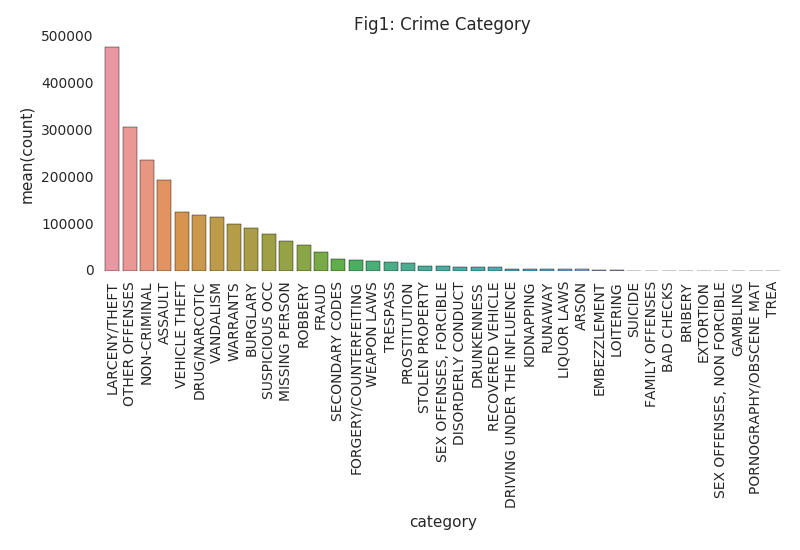

In [24]:
# Plot crime category by seaborn
q1_result_pd_df = q1_result.toPandas()

fig, ax = plt.subplots()
ax.set_title('Fig1: Crime Category')
ax = sb.barplot(x = 'category', y = 'count', data = q1_result_pd_df)
ax.set_xticklabels(q1_result_pd_df['category'], rotation=90)
plt.tight_layout()
display(fig)

#### Q2 question (OLAP)
Counts the number of crimes for different district, and visualize your results

In [26]:
# Method 1: Data Frame based
q2_result = df.groupBy('PdDistrict').count().orderBy('count', ascending = False)
q2_result.show()

+----------+------+
PdDistrict| count|
+----------+------+
 SOUTHERN|399785|
 MISSION|300076|
 NORTHERN|272713|
 CENTRAL|226255|
 BAYVIEW|221000|
 INGLESIDE|194180|
TENDERLOIN|191746|
 TARAVAL|166971|
 PARK|125479|
 RICHMOND|116818|
 | 1|
+----------+------+

In [27]:
# Method 2: SQL based
sqlDF = spark.sql('select PdDistrict, count(*) as Count from sf_crime group by PdDistrict order by Count desc').show()

+----------+------+
PdDistrict| Count|
+----------+------+
 SOUTHERN|399785|
 MISSION|300076|
 NORTHERN|272713|
 CENTRAL|226255|
 BAYVIEW|221000|
 INGLESIDE|194180|
TENDERLOIN|191746|
 TARAVAL|166971|
 PARK|125479|
 RICHMOND|116818|
 | 1|
+----------+------+

In [28]:
# Method 3: RDD function
rdd = crimes.map(lambda line: (line[6], 1))
display(sorted(rdd.countByKey().items(), key = lambda x: -x[1]))

_1,_2
SOUTHERN,399785
MISSION,300076
NORTHERN,272713
CENTRAL,226255
BAYVIEW,221000
INGLESIDE,194180
TENDERLOIN,191746
TARAVAL,166971
PARK,125479
RICHMOND,116818


In [29]:
df.select('PdDistrict').distinct().show()

+----------+
PdDistrict|
+----------+
 MISSION|
 BAYVIEW|
 CENTRAL|
 TARAVAL|
TENDERLOIN|
 INGLESIDE|
 PARK|
 SOUTHERN|
 RICHMOND|
 |
 NORTHERN|
+----------+

In [30]:
df = df.filter(df.PdDistrict.isin(['MISSION','BAYVIEW','CENTRAL','TARAVAL','TENDERLOIN','INGLESIDE','PARK','SOUTHERN','RICHMOND','NORTHERN']))
df.select('PdDistrict').distinct().show()

+----------+
PdDistrict|
+----------+
 MISSION|
 BAYVIEW|
 CENTRAL|
 TARAVAL|
TENDERLOIN|
 INGLESIDE|
 PARK|
 SOUTHERN|
 RICHMOND|
 NORTHERN|
+----------+

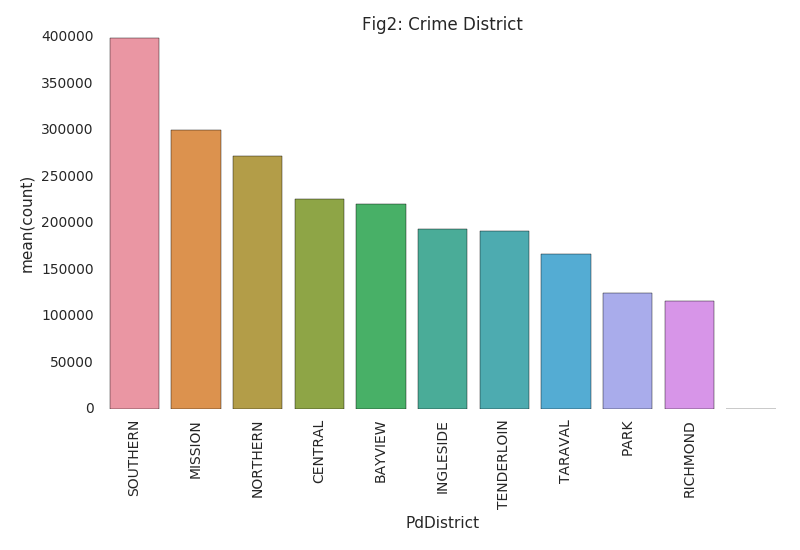

In [31]:
# Plot crime district by seaborn
q2_result_pd_df = q2_result.toPandas()

fig, ax = plt.subplots()
ax.set_title('Fig2: Crime District')
ax = sb.barplot(x = 'PdDistrict', y = 'count', data = q2_result_pd_df)
ax.set_xticklabels(q2_result_pd_df['PdDistrict'], rotation=90)
plt.tight_layout()
display(fig)

With the latitude and the longitude, we can count the number of incidents within a certain area we define. 
### Q3 question (OLAP)
Count the number of crimes each "Sunday" at "SF downtown".
Here I define "SF downtown" as an area within 0.005 degree from (lat, long) = (37.792489, -122.403221). This area is roughly includes Finantial District, China Town and Union Square.

In [33]:
# Method 1: Data Frame
df_downtown = df.filter((df['Latitude'] - 37.792489)**2 + (df['Longitude'] + 122.403221)**2 < 0.005**2)
df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday').groupBy("Date", "DayOfWeek").count().orderBy('Date').show()

+----------+---------+-----+
 Date|DayOfWeek|count|
+----------+---------+-----+
01/01/2006| Sunday| 16|
01/01/2012| Sunday| 14|
01/01/2017| Sunday| 15|
01/02/2005| Sunday| 4|
01/02/2011| Sunday| 4|
01/03/2010| Sunday| 6|
01/03/2016| Sunday| 8|
01/04/2004| Sunday| 8|
01/04/2009| Sunday| 4|
01/04/2015| Sunday| 13|
01/05/2003| Sunday| 9|
01/05/2014| Sunday| 4|
01/06/2008| Sunday| 5|
01/06/2013| Sunday| 6|
01/07/2007| Sunday| 5|
01/07/2018| Sunday| 13|
01/08/2006| Sunday| 3|
01/08/2012| Sunday| 4|
01/08/2017| Sunday| 8|
01/09/2005| Sunday| 6|
+----------+---------+-----+
only showing top 20 rows

In [34]:
from pyspark.sql import functions as F

We can also filter the downtown area by defining a udf

In [36]:
# udf function to filter downtown area
@F.udf(returnType = BooleanType())

def downtown_filter(lat, long):
  return ((lat - 37.792489)**2 + (long + 122.403221)**2) < 0.005**2

In [37]:
df_downtown = df.filter(downtown_filter('Latitude', 'Longitude'))
df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday').groupBy('Date', 'DayOfWeek').count().orderBy('Date').show()

+----------+---------+-----+
 Date|DayOfWeek|count|
+----------+---------+-----+
01/01/2006| Sunday| 16|
01/01/2012| Sunday| 14|
01/01/2017| Sunday| 15|
01/02/2005| Sunday| 4|
01/02/2011| Sunday| 4|
01/03/2010| Sunday| 6|
01/03/2016| Sunday| 8|
01/04/2004| Sunday| 8|
01/04/2009| Sunday| 4|
01/04/2015| Sunday| 13|
01/05/2003| Sunday| 9|
01/05/2014| Sunday| 4|
01/06/2008| Sunday| 5|
01/06/2013| Sunday| 6|
01/07/2007| Sunday| 5|
01/07/2018| Sunday| 13|
01/08/2006| Sunday| 3|
01/08/2012| Sunday| 4|
01/08/2017| Sunday| 8|
01/09/2005| Sunday| 6|
+----------+---------+-----+
only showing top 20 rows

In [38]:
# Method 2: SQL
sqlDF = spark.sql("select Date, DayOfWeek, count(*) as Count from sf_crime where DayOfWeek = 'Sunday' and pow(Latitude - 37.792489, 2) + pow(Longitude + 122.403221, 2) < pow(0.005, 2) group by Date, DayOfWeek order by Date").show()

+----------+---------+-----+
 Date|DayOfWeek|Count|
+----------+---------+-----+
01/01/2006| Sunday| 16|
01/01/2012| Sunday| 14|
01/01/2017| Sunday| 15|
01/02/2005| Sunday| 4|
01/02/2011| Sunday| 4|
01/03/2010| Sunday| 6|
01/03/2016| Sunday| 8|
01/04/2004| Sunday| 8|
01/04/2009| Sunday| 4|
01/04/2015| Sunday| 13|
01/05/2003| Sunday| 9|
01/05/2014| Sunday| 4|
01/06/2008| Sunday| 5|
01/06/2013| Sunday| 6|
01/07/2007| Sunday| 5|
01/07/2018| Sunday| 13|
01/08/2006| Sunday| 3|
01/08/2012| Sunday| 4|
01/08/2017| Sunday| 8|
01/09/2005| Sunday| 6|
+----------+---------+-----+
only showing top 20 rows

### Q4 question (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

In [40]:
from pyspark.sql.functions import *

In [41]:
# Method 1. Data frame
# Convert "Date" to a form of "yyyy-mm-dd" and create another column "Month"
df = df.withColumn("Date", F.to_date(df["Date"], format = "MM/dd/yyyy"))

In [42]:
# add three columns as day, month, and year for further query
df = df.withColumn("day", dayofmonth(df.Date))
df = df.withColumn("month", month(df.Date))
df = df.withColumn("year", year(df.Date))

In [43]:
q4_result = df.filter(df['year'] > 2014).groupBy("year","month").count().orderBy("year", ascending = False)
q4_result.show()

+----+-----+-----+
year|month|count|
+----+-----+-----+
2018| 1|12031|
2018| 4|10306|
2018| 3|10740|
2018| 5| 3644|
2018| 2| 9947|
2017| 6|12605|
2017| 9|12684|
2017| 11|12347|
2017| 4|12941|
2017| 12|12544|
2017| 8|12872|
2017| 5|13267|
2017| 3|13711|
2017| 2|12192|
2017| 7|13171|
2017| 10|13355|
2017| 1|13084|
2016| 11|12720|
2016| 5|12732|
2016| 7|12191|
+----+-----+-----+
only showing top 20 rows

In [44]:
def crime_per_month(df, yr):
  df_per_yr = df[df.year == yr].sort_values(by = "month")
  return df_per_yr

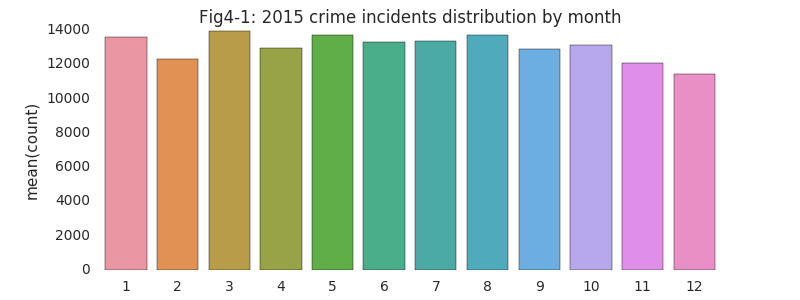

In [45]:
# crime per month in 2015 plot by seabornn
q4_result_pd_df = q4_result.toPandas()

fig, ax = plt.subplots(figsize = (8, 3))
df_2015 = crime_per_month(q4_result_pd_df, 2015)
ax.set_title('Fig4-1: 2015 crime incidents distribution by month')
ax = sb.barplot(x = 'month', y = 'count', data = df_2015)
ax.set_xticklabels(df_2015['month'])
display(fig)

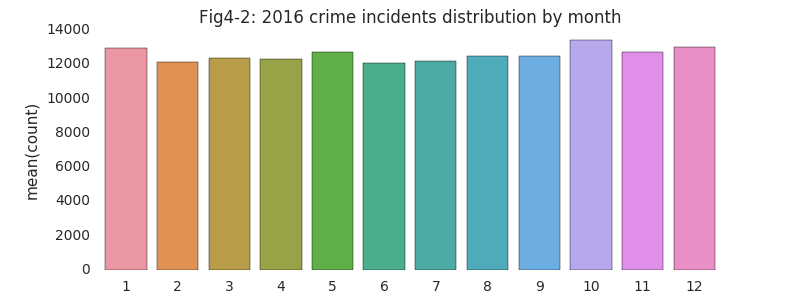

In [46]:
# crime per month in 2016 plot by seabornn
q4_result_pd_df = q4_result.toPandas()

fig, ax = plt.subplots(figsize = (8, 3))
df_2016 = crime_per_month(q4_result_pd_df, 2016)
ax.set_title('Fig4-2: 2016 crime incidents distribution by month')
ax = sb.barplot(x = 'month', y = 'count', data = df_2016)
ax.set_xticklabels(df_2016['month'])
display(fig)

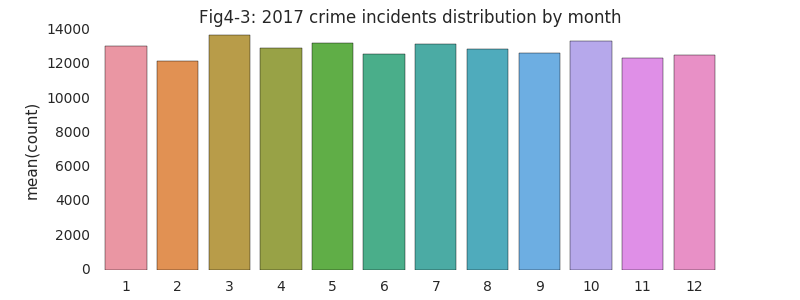

In [47]:
# crime per month in 2017 plot by seabornn
q4_result_pd_df = q4_result.toPandas()

fig, ax = plt.subplots(figsize = (8, 3))
df_2017 = crime_per_month(q4_result_pd_df, 2017)
ax.set_title('Fig4-3: 2017 crime incidents distribution by month')
ax = sb.barplot(x = 'month', y = 'count', data = df_2017)
ax.set_xticklabels(df_2017['month'])
display(fig)

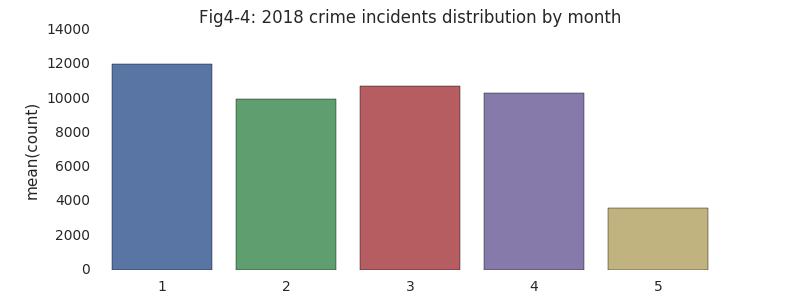

In [48]:
# crime per month in 2018 plot by seabornn
q4_result_pd_df = q4_result.toPandas()

fig, ax = plt.subplots(figsize = (8, 3))
df_2018 = crime_per_month(q4_result_pd_df, 2018)
ax.set_title('Fig4-4: 2018 crime incidents distribution by month')
ax = sb.barplot(x = 'month', y = 'count', data = df_2018)
ax.set_xticklabels(df_2018['month'])
display(fig)

Business impact: 
* From the plots above ,we can see a slightly drop of crime incidents in Febrary each recent year, it might due to cold weather, less tourists will be in SF in Febrary thus less crimes. This is kind of seasonality effect.
* Thus tourists are recommended to visit SF in Febrary but remember to bring more clothes.
* For police distribution, SFPD can distribute less police force in Febrary. Thus taking seasonality effect into consideration is useful for goverment department budget and local security enhancement.

### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certain day like 2015/12/15, 2016/12/15, 2017/12/15. Then, give your travel suggestions to visit SF.

In [51]:
def day_filter(df, yr, mon, day):
  df_filter = df[(df.year == yr) & (df.month == mon) & (df.day == day)]
  return df_filter

In [52]:
df_2015_12_15 = day_filter(df, 2015, 12, 15)
df_2016_12_15 = day_filter(df, 2016, 12, 15)
df_2017_12_15 = day_filter(df, 2017, 12, 15)

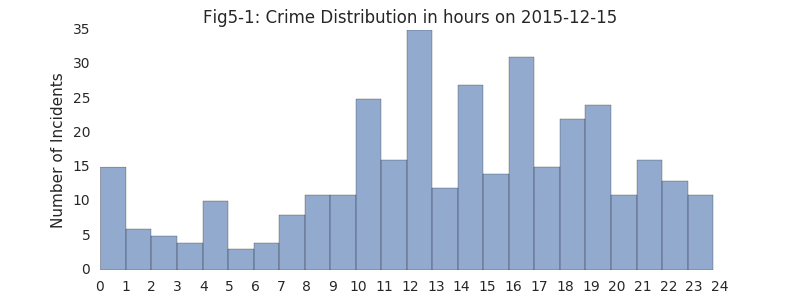

In [53]:
# crime distribution in hours on 2015-12-15 plot by seaborn
q5_result_2015_pd_df = df_2015_12_15.toPandas()
q5_result_2015_pd_df['Time_float'] = q5_result_2015_pd_df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

# visulize in a bar plot by seaborn
fig, ax = plt.subplots(figsize=[8,3])
ax.hist(q5_result_2015_pd_df['Time_float'], bins=24, alpha = 0.6)
ax.set_xlabel('Time of a day')
ax.set_ylabel('Number of Incidents')
ax.set_xlim((0, 24))
ax.set_xticks( np.arange(0, 25) )
ax.set_title('Fig5-1: Crime Distribution in hours on 2015-12-15')
display(fig)

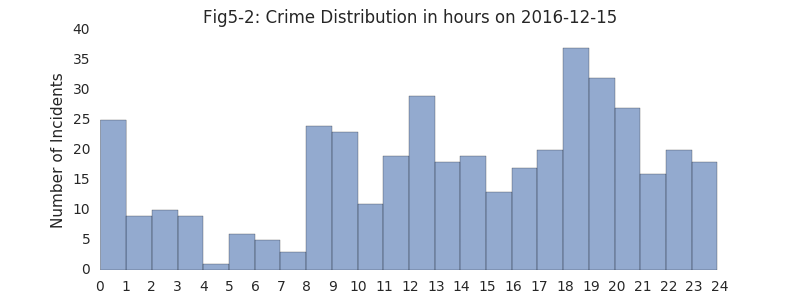

In [54]:
# crime distribution in hours on 2016-12-15 plot by seaborn
q5_result_2016_pd_df = df_2016_12_15.toPandas()
q5_result_2016_pd_df['Time_float'] = q5_result_2016_pd_df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

# visulize in a bar plot by seaborn
fig, ax = plt.subplots(figsize=[8,3])
ax.hist(q5_result_2016_pd_df['Time_float'], bins=24, alpha = 0.6)
ax.set_xlabel('Time of a day')
ax.set_ylabel('Number of Incidents')
ax.set_xlim((0, 24))
ax.set_xticks( np.arange(0, 25) )
ax.set_title('Fig5-2: Crime Distribution in hours on 2016-12-15')
display(fig)

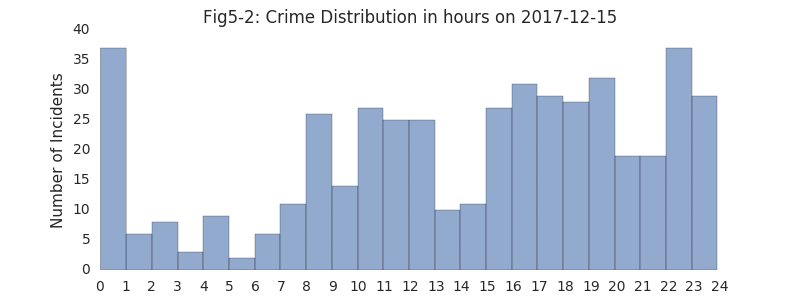

In [55]:
# crime distribution in hours on 2017-12-15 plot by seaborn
q5_result_2017_pd_df = df_2017_12_15.toPandas()
q5_result_2017_pd_df['Time_float'] = q5_result_2017_pd_df.Time.map(lambda x: int(x.split(':')[0]) + float(x.split(':')[1])/60)

# visulize in a bar plot by seaborn
fig, ax = plt.subplots(figsize=[8,3])
ax.hist(q5_result_2017_pd_df['Time_float'], bins=24, alpha = 0.6)
ax.set_xlabel('Time of a day')
ax.set_ylabel('Number of Incidents')
ax.set_xlim((0, 24))
ax.set_xticks( np.arange(0, 25) )
ax.set_title('Fig5-2: Crime Distribution in hours on 2017-12-15')
display(fig)

Takeouts:
* Based on the bar plots above, we can see an apparent decreasement of crime in midnight. Overall, the lowest crime hour is at around 5AM.
* The crime rate is lower in morning till noon, but higher in afternoon till midnight.
Suggestions for visitors:
* Always keep an eye on your personal belongings.
* Departure early, visit sightseeings in morning if possible.

### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [58]:
# Step 1: Find out the top-3 dangerous district
# Method 1: SQL based
sqlDF = spark.sql('select PdDistrict, count(*) as Count from sf_crime group by PdDistrict order by count(*) DESC limit 3')
sqlDF.show()

+----------+------+
PdDistrict| Count|
+----------+------+
 SOUTHERN|399785|
 MISSION|300076|
 NORTHERN|272713|
+----------+------+

In [59]:
# Method 2: Data frame based
df_q6 = df.groupBy('PdDistrict').count().orderBy('count', ascending=False)
display(df_q6)

PdDistrict,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713
CENTRAL,226255
BAYVIEW,221000
INGLESIDE,194180
TENDERLOIN,191746
TARAVAL,166971
PARK,125479
RICHMOND,116818


In [60]:
df_q6 = df.filter(df.PdDistrict.isin(['MISSION', 'SOUTHERN', 'NORTHERN']))
display(df_q6)

:@computed_region_2dwj_jsy4,:@computed_region_4isq_27mq,:@computed_region_6ezc_tdp2,:@computed_region_6pnf_4xz7,:@computed_region_9dfj_4gjx,:@computed_region_9jxd_iqea,:@computed_region_bh8s_q3mv,:@computed_region_fcz8_est8,:@computed_region_fyvs_ahh9,:@computed_region_h4ep_8xdi,:@computed_region_n4xg_c4py,:@computed_region_nqbw_i6c3,:@computed_region_p5aj_wyqh,:@computed_region_pigm_ib2e,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,Address,Analysis Neighborhoods,Category,Current Police Districts,Current Supervisor Districts,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,SF Find Neighborhoods,Time,Longitude,Latitude,day,month,year
,,,2,,,28853,1,34,,1,1,2,,9,8,700 Block of TEHAMA ST,34,VEHICLE THEFT,1,10,2018-05-15,Tuesday,STOLEN MOTORCYCLE,180362289,"(37.77520656149669, -122.41191202732877)",SOUTHERN,18036228907023,NONE,32,10:30,-122.41191,37.775208,15,5,2018
,,1,2,,8,28853,1,19,1,1,1,2,,9,8,MARKET ST / SOUTH VAN NESS AV,20,NON-CRIMINAL,1,10,2018-05-15,Tuesday,"AIDED CASE, MENTAL DISTURBED",180360948,"(37.77514629165388, -122.41925789481357)",SOUTHERN,18036094864020,NONE,32,04:14,-122.41926,37.775146,15,5,2018
,15,,2,13,,28859,3,19,,,3,4,15,7,2,CAPP ST / 21ST ST,20,OTHER OFFENSES,3,2,2018-05-15,Tuesday,PAROLE VIOLATION,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087926150,"ARREST, BOOKED",53,02:01,-122.417816,37.7571,15,5,2018
,15,,2,13,,28859,3,19,,,3,4,15,7,2,CAPP ST / 21ST ST,20,OTHER OFFENSES,3,2,2018-05-15,Tuesday,TRAFFIC VIOLATION ARREST,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087965010,"ARREST, BOOKED",53,02:01,-122.417816,37.7571,15,5,2018
,15,,2,13,,28859,3,19,,,3,4,15,7,2,CAPP ST / 21ST ST,20,OTHER OFFENSES,3,2,2018-05-15,Tuesday,TRAFFIC VIOLATION,180360879,"(37.757100579642824, -122.41781255878655)",MISSION,18036087965015,"ARREST, BOOKED",53,02:01,-122.417816,37.7571,15,5,2018
,,,2,,,28859,3,19,,,3,4,,7,2,700 Block of SHOTWELL ST,20,OTHER OFFENSES,3,2,2018-05-15,Tuesday,"DRIVERS LICENSE, SUSPENDED OR REVOKED",180360829,"(37.75641376904809, -122.41561725232026)",MISSION,18036082965016,NONE,53,01:27,-122.41562,37.756413,15,5,2018
,18,1,2,17,7,28853,1,34,1,1,1,2,18,9,14,0 Block of 6TH ST,34,ROBBERY,5,10,2018-05-15,Tuesday,"ROBBERY, BODILY FORCE",180360835,"(37.781953653725715, -122.41004163181597)",SOUTHERN,18036083503074,"ARREST, BOOKED",32,01:25,-122.41004,37.78195,15,5,2018
,18,1,2,17,7,28853,1,34,1,1,1,2,18,9,14,0 Block of 6TH ST,34,DRUG/NARCOTIC,5,10,2018-05-15,Tuesday,POSSESSION OF NARCOTICS PARAPHERNALIA,180360835,"(37.781953653725715, -122.41004163181597)",SOUTHERN,18036083516710,"ARREST, BOOKED",32,01:25,-122.41004,37.78195,15,5,2018
,15,,2,13,,28859,3,19,,,3,4,15,7,2,20TH ST / CAPP ST,20,PROSTITUTION,3,2,2018-05-14,Monday,LOITERING FOR PURPOSE OF PROSTITUTION,180360788,"(37.75869681664891, -122.41796448376013)",MISSION,18036078813075,NONE,53,23:43,-122.41796,37.758698,14,5,2018
,15,,2,13,,28859,3,19,,,3,4,15,7,2,20TH ST / CAPP ST,20,OTHER OFFENSES,3,2,2018-05-14,Monday,RESISTING ARREST,180360788,"(37.75869681664891, -122.41796448376013)",MISSION,18036078827170,NONE,53,23:43,-122.41796,37.758698,14,5,2018


In [61]:
# Step 2: Find out the crime event w.r.t category and time (hour) from the result of step 1
# Crime even w.r.t category
display(df.filter(df['PdDistrict'].isin ('SOUTHERN', 'MISSION', 'NORTHERN')).groupBy('Category').count().orderBy('count', ascending=False))

Category,count
LARCENY/THEFT,243290
OTHER OFFENSES,129739
NON-CRIMINAL,108217
ASSAULT,81163
DRUG/NARCOTIC,50903
WARRANTS,49254
VANDALISM,46032
VEHICLE THEFT,43573
BURGLARY,36500
SUSPICIOUS OCC,31785


In [62]:
df = df.withColumn("hour", df.Time.substr(1,2))

In [63]:
# Crime even w.r.t hour
display(df.filter(df['PdDistrict'].isin ('SOUTHERN', 'MISSION', 'NORTHERN')).groupBy('hour').count().orderBy('hour'))

hour,count
00,51440
01,31619
02,26034
03,16761
04,11658
05,9823
06,14657
07,23091
08,34523
09,38255


Advice: 
* More police power should be distributed to deal with ``LARCENY/THEFT``, ``OTHER OFFENSES``. 
* At around 4 AM to 5 AM, SF is relatively peaceful. According to analysis on hours, more police power should be distributed during afternoon till midnight.

#### Q7 question (OLAP)
For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

In [66]:
display(df.groupBy('Resolution').count().orderBy('count', ascending=False))

Resolution,count
NONE,1389499
"ARREST, BOOKED",524979
"ARREST, CITED",154789
LOCATED,34463
PSYCHOPATHIC CASE,29185
UNFOUNDED,23799
JUVENILE BOOKED,14158
COMPLAINANT REFUSES TO PROSECUTE,8089
DISTRICT ATTORNEY REFUSES TO PROSECUTE,7955
NOT PROSECUTED,7720


The cases not resolved take more than a half.